# 1.데이터불러오기

# 개선해야할 점
    1) title+content 형태소 분석 & word2vec
    2) [사진,포토] 등 불필요한 단어 제거,한자제거,
  
    3) 불용어처리 가능하게 하기 

In [1]:
import re
import pandas as pd
import numpy as np
import json
#from bs4 import Beautiful Soup
# from nltk.corpus import Beautiful Soup
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import konlp
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#헤더추가 (title,content,time)
train =pd.read_csv('dataset3000.csv',names=['title','content','time','nan'])
train.head()
train.shape
train.dtypes

title       object
content     object
time        object
nan        float64
dtype: object

In [3]:
train.head()

,title,content,time,nan
0,"'[사진]조여정,'우아한 플라워원피스 입고''",'제24회 춘사영화제는 ‘아시아를 대표하는 영화제로의 도약’을 표방한 제23회에 이...,2019-07-20 16:40,NaN
1,'[프로필]국세청 과장급 전보자(7월 22일 자)','조사기획1계장 ▲경주세무서장 ▲국세청 인도네시아 주재관 ▲외교부 파견 ▲서울지방국...,2019-07-20 16:40,NaN
2,'[조이HD]춘사영화제 참석한 봉준호 감독-한진원 작가','말레이시아 Finas(말레시아 영화진흥위)의 신임 대표인 Ahmad Idham을 ...,2019-07-20 16:40,NaN
3,"'[사진]클라라,'시선 올킬 블루 롱드레스''",'제24회 춘사영화제는 ‘아시아를 대표하는 영화제로의 도약’을 표방한 제23회에 이...,2019-07-20 16:40,NaN
4,"'[사진]7개부문 노미네이트 기생충 봉준호 감독,'엄청난 환호 받으며''",'제24회 춘사영화제는 ‘아시아를 대표하는 영화제로의 도약’을 표방한 제23회에 이...,2019-07-20 16:40,NaN


In [4]:
# nan 변수버리기
train.drop(['nan'], axis='columns', inplace=True)

In [5]:
train.tail()

,title,content,time
2868,"'[포토] ABCC FINTECH INDONESIA, 양해각서(MOU) 체결'","'시사매거진, SISAMAGAZINE 8월 1일 오후 4시(현지시간) 인도네시아 자...",2019-08-01 20:00
2869,"'옥천 복숭아, 홍콩 시장 공략 나서'","'한편, 옥천군복숭아수출협의회는 2017년 인도네시아에 0.7t(4천522달러), ...",2019-08-01 20:00
2870,'‘애인과 혼전 성관계’ 때문에 어느 20대 여성이 받은 무시무시한 처벌','혼전 성관계를 가진 인도네시아 남녀가 공개 태형을 당했다고 서울신문 나우뉴스가 1...,2019-08-01 20:00
2871,"'부산대병원 개발 '의료영상저장전송시스템', 카자흐스탄서 맹활약'",'세계 시장에서 경쟁할 수 있는 수준의 '엔터프라이즈 데이터 플랫폼' 개발을 위해 ...,2019-08-01 20:00
2872,"'aT 인도네시아서 K-Food 2,235만불 수출상담등 쾌거'",'인도네시아에서 '2019 자카르타 K-Food Fair' 행사를 개최해 총 2천2...,2019-08-01 20:00


In [6]:
train.shape

(2873, 3)

# 2.데이터전처리

In [7]:
 # 데이터개수
 print('학습 데이터의 개수: {}'.format(len(train)))

학습 데이터의 개수: 2873


In [8]:
# title(제목) 컬럼 문자길이
train_title_len=train['title'].apply(len)
train_title_len.head()

0    25
1    28
2    31
3    25
4    40
Name: title, dtype: int64

In [9]:
# content(내용) 컬럼 문자길이
train_content_len=train['content'].apply(len)
train_content_len.head()

0    127
1    115
2    129
3    127
4    127
Name: content, dtype: int64

Text(0, 0.5, 'Number of review')

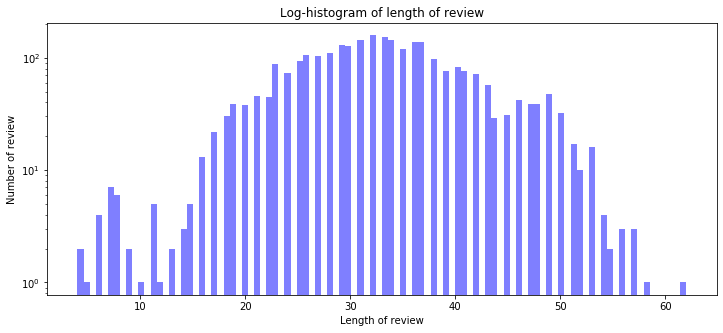

In [10]:
# title 문자길이 분포

#그래프에 대한 이미지 크기 선언
#figsize : (가로,세로) 형태의 튜플로 입력
plt.figure(figsize=(12,5))
#히스토그램 선언
# bins: 히스토그램 값에 대한 버킷 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color :그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_title_len, bins=100, alpha=0.5, color='b',label='word')
plt.yscale('log',nonposy='clip')
#그래프 제목
plt.title('Log-histogram of length of review')
#그래프 x축 라벨
plt.xlabel('Length of review')
#그래프 y축 라벨
plt.ylabel('Number of review')

In [11]:
# title 길이 통계값
print('제목 길이 최댓값: {}'.format(np.max(train_title_len)))
print('제목 길이 최솟값: {}'.format(np.min(train_title_len)))
print('제목 길이 평균값: {:.2f}'.format(np.mean(train_title_len)))
print('제목 길이 표준편차: {:.2f}'.format(np.std(train_title_len)))
print('제목 길이 중간값 {}'.format(np.median(train_title_len)))
print('제목 길이 제1사분위: {}'.format(np.percentile(train_title_len,25)))
print('제목 길이 제3사분위: {}'.format(np.percentile(train_title_len,75)))     
    
                    

제목 길이 최댓값: 62
제목 길이 최솟값: 4
제목 길이 평균값: 32.98
제목 길이 표준편차: 8.47
제목 길이 중간값 33.0
제목 길이 제1사분위: 27.0
제목 길이 제3사분위: 38.0


Text(0, 0.5, 'Number of review')

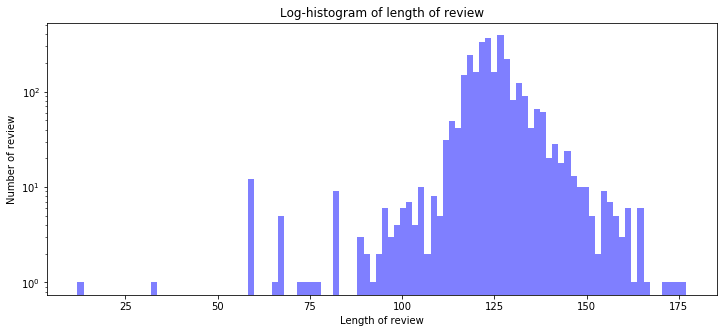

In [12]:
# content 문자길이 분포
# title 문자길이 분포

#그래프에 대한 이미지 크기 선언
#figsize : (가로,세로) 형태의 튜플로 입력
plt.figure(figsize=(12,5))
#히스토그램 선언
# bins: 히스토그램 값에 대한 버킷 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color :그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_content_len, bins=100, alpha=0.5, color='b',label='word')
plt.yscale('log',nonposy='clip')
#그래프 제목
plt.title('Log-histogram of length of review')
#그래프 x축 라벨
plt.xlabel('Length of review')
#그래프 y축 라벨
plt.ylabel('Number of review')

In [13]:
# content 길이 통계값
print('내용 길이 최댓값: {}'.format(np.max(train_content_len)))
print('내용 길이 최솟값: {}'.format(np.min(train_content_len)))
print('내용 길이 평균값: {:.2f}'.format(np.mean(train_content_len)))
print('내용 길이 표준편차: {:.2f}'.format(np.std(train_content_len)))
print('내용 길이 중간값 {}'.format(np.median(train_content_len)))
print('내용 길이 제1사분위: {}'.format(np.percentile(train_content_len,25)))
print('내용 길이 제3사분위: {}'.format(np.percentile(train_content_len,75)))     
    

내용 길이 최댓값: 177
내용 길이 최솟값: 12
내용 길이 평균값: 124.67
내용 길이 표준편차: 10.98
내용 길이 중간값 124.0
내용 길이 제1사분위: 120.0
내용 길이 제3사분위: 129.0


(-0.5, 799.5, 599.5, -0.5)

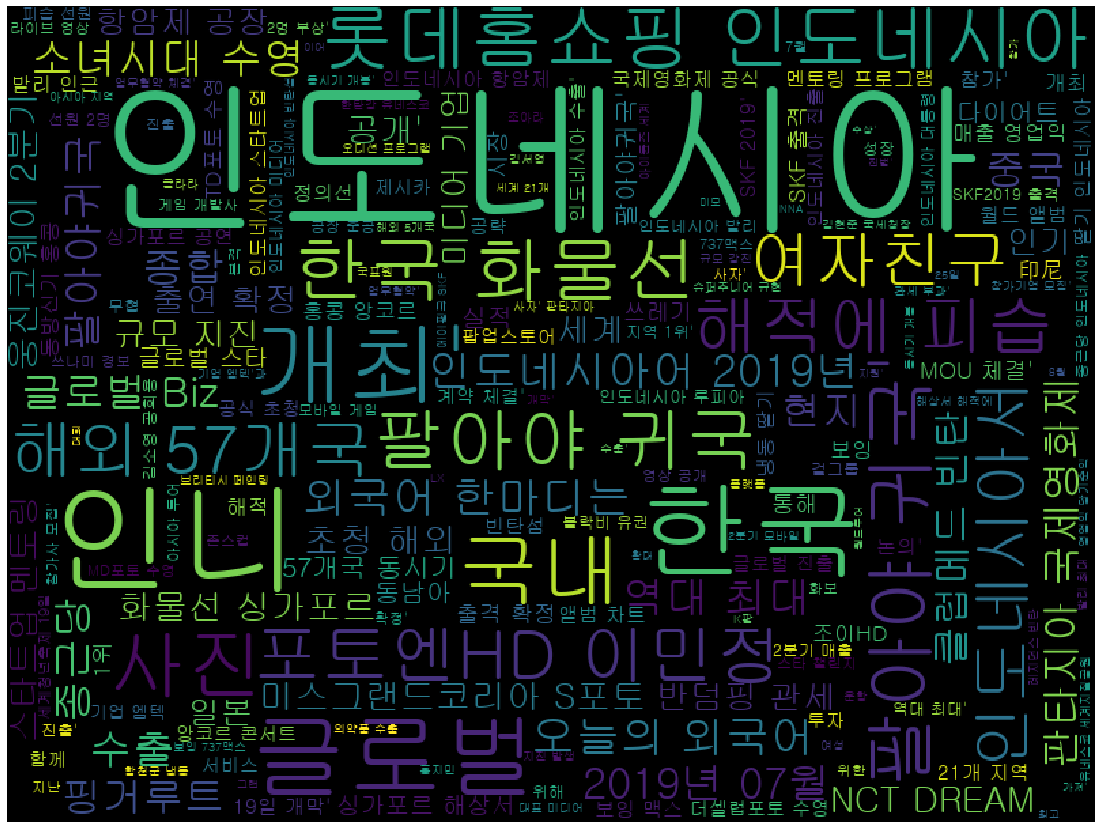

In [14]:
#wordcloud
# title(제목) 많이 사용된 단어
from wordcloud import WordCloud
cloud=WordCloud(width=800,height=600,font_path='C:/Users/glass/Downloads/gulim.ttc').generate(" ".join(train['title']))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

In [15]:
tokens = [j for i in train['title'] for j in i]


import nltk

text = nltk.Text(tokens) 


import matplotlib.pyplot as plt
from matplotlib import font_manager, rc 
from matplotlib import font_manager, rc

font_fname = 'C:/Users/glass/Downloads/gulim.ttc'     # A font of your choice

font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)


fig = plt.figure()
fig.set_label('test')
plt.figure(figsize=(20, 10)) 
text.plot(50)

RuntimeError: In FT2Font: Can not load face.  Unknown file format.

# 3.데이터정제
###  여기서는 'title'로 했다.

# konlpy 사용하기! #다운 필요jype

# [사진], [포토] 지우기!

In [ ]:
train.head()

In [ ]:
title=list(train['title'])

In [ ]:
from konlpy.tag import Okt

In [ ]:
train.dtypes

In [ ]:
train1=train

In [ ]:
# 여기서 train을 str로 선언하면 나중에 for문을 쓰지 못한다.

In [ ]:
#전체제목
# 리스트전체가 아니라 하나씩 빼서 처리해야하기 때문에 for문으로 처리.
#1.한글 및 공백을 제외한 문자를 모두 제거
for i in range(len(title)) :
    title[i] = re.sub("[^가-힣ㄱ-ㅎ ㅏ-ㅣ\\s]","", title[i])

print(title)

In [ ]:
#전체 형태소나누기
#불용어 제거하기 위해 문장 단어 나누기
okt=Okt() 
title_text=[ ] # or title_text=[''] * len(title)
for i in range(len(title)) :
    title_text.append(okt.morphs(title[i],stem=True))

print(title_text[:10])

In [ ]:
# 불용어제거
stop_words=['우아하다']
#clean_title=[token for w in title_text if not token in stop_words]
#print(clean_title[:10])'
result=[]
for w in title_text:
    if w not in stop_words:
        result.append(w)
        
print (result )

In [ ]:
test = []
stop_words=['우아하다']
for i in range(len(title_text)):
    j = 0
    while(j < len(title_text[i])):
        if(title_text[i][j] in stop_words):
            title_text[i].remove(title_text[i][j])
            continue
        j += 1
    test.append(title_text[i])

print(test)

## 전처리과정 전체 적용 함수 

In [ ]:
def preprocessing(train,okt,remove_stopwords=False,stop_words=[]):
    #train: 전처리할 텍스트
    #okt:okt 객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    #remove_stopword:불용어를 제거할지 여부 선택, 기본값은 False
    #stop_word:불용어 사전은 사용자가 직접입력해야함. 기본값은 빈 리스트
    
    #1.한글 및 공백을 제외한 문자를 모두 제거
    title_text=re.sub("[^가-힣ㄱ-ㅎ ㅏ-ㅣ\\s]","",str(train['title']))
    
    #2. okt객체를 활용해 형태소 단위로 나눈다.
    title_text=okt.morphs(str(title_text),stem=True)
    
    if remove_stopwords:
        #불용어 제거(선택적)
        title_text=[token for token in title_text if not token in stop_words]
    
    return title_text

In [ ]:
print(title_text)def preprocessing(train,okt,remove_stopwords=False,stop_words=[]):
    #train: 전처리할 텍스트
    #okt:okt 객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    #remove_stopword:불용어를 제거할지 여부 선택, 기본값은 False
    #stop_word:불용어 사전은 사용자가 직접입력해야함. 기본값은 빈 리스트
    
    #1.한글 및 공백을 제외한 문자를 모두 제거
    title_text=re.sub("[^가-힣ㄱ-ㅎ ㅏ-ㅣ\\s]","",str(train['title']))
    
    #2. okt객체를 활용해 형태소 단위로 나눈다.
    title_text=okt.morphs(str(title_text),stem=True)
    
    if remove_stopwords:
        #불용어 제거(선택적)
        title_text=[token for token in title_text if not token in stop_words]
    
    return title_text

In [ ]:
# 함수실행

# 불용어정의
stop_words=['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한','및','듯','료']

okt=Okt()

clean_train_title=[]

## 여기서 train 무엇인지... 다시 보기 p.224
for train in train['title']:
    #비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(train) == str:
        clean_train_title.append(preprocessing(train,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_title.append([]) # string이 아니면 비어있는 값 추가
        
clean_train_title[:4] #앞의 4개 데이터확인
    

# train1

In [ ]:
train.head()

In [ ]:
# train1

# 함수실행
# 불용어정의
stop_words=['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한','및','듯','료']

okt=Okt()

clean_train_title=[]

## 여기서 train 무엇인지... 다시 보기 p.224
for train1 in train1['title']:
    #비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(train) == str:
        clean_train_title.append(preprocessing(train1,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_title.append([]) # string이 아니면 비어있는 값 추가
        
clean_train_title[:4] #앞의 4개 데이터확인
    

In [ ]:
# 불용어 .txt 파일로 적용
def tokenize_new(doc):
    x = [line.rstrip('\n') for line in open('C:/Users/DongA2/Final_Final_Disertation/File/new_stop.txt', 'r', encoding='utf-8')]
    word_tokens = tagger.nouns(doc)
    result = [] 
    
    for w in word_tokens: 
        if w not in x: 
            
            result.append(w) 
    return result

In [ ]:
# content 전체전처리 #return word_

In [ ]:
# 단어최대길이설정

In [ ]:
# 벡터표상화

# 4.word2vec 벡터화

In [ ]:
#word2vec 파라미터 설명
# workers =프로세스개수
# size= 워드 벡터 특징값수(벡터의 차원을 정한다.)
# min_count =단어에 대한 최소 빈도수(적은 빈도수의 단어는 학습하지 않는다. )
# window =컨테스트 윈도우 크기
# sample=샘플링 비율 (Ex)1e-3 :0.001이 좋은 성능을 낸다

num_workers=4
num_size=300
min_word_count=40
context=10
downsampling=1e-3

In [ ]:
#진행상황확인위해
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)



In [ ]:
from gensim.models import Word2Vec
print("Training model...")
model= Word2Vec(title_text, size=300, window=5, min_count=5, workers=4, sg=1)



In [ ]:
model.most_similar("감", topn=10)

In [ ]:
model.most_similar("사전", topn=10)

In [ ]:
model.most_similar("설립", topn=10)

In [ ]:
model.most_similar("사진", topn=10)

In [ ]:
#위에 껄로 학습완료

#모델 하이퍼파라미터를 설정한 내용을 모델 이름에 담는 다면 나중에 참고하기에 좋을 것이다.
#모델을 저장하면 Word2Vec.load()를 통해 모델을 다시 사용할 수 있다. 
#model_name="300features_40minwords_10context"
############ model.save(model_name)

# 5. 텍스트 유사도

# trian 과 test 나누기 